# 利用fbprophet预测新冠疫情期间的供水总量论文

**2020年3月1日prophet预测三月供水总量**

In [23]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
mpl.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime as dt

In [24]:

sup_water = pd.read_excel(r'~/mypyworks/自来水数据/2015-2020日供水总量.xlsx')

In [25]:
sup_water

,QUOTA_DATE,最低温度,最高温度,水厂供水总量
0,2015-01-01,15.0,21.0,3941482.0
1,2015-01-02,6.0,20.0,3903494.0
2,2015-01-03,13.0,21.0,4055444.0
3,2015-01-04,8.0,22.0,4077068.0
4,2015-01-05,16.0,23.0,4062857.0
...,...,...,...,...
1925,2020-04-09,17.0,28.0,4339059.0
1926,2020-04-10,17.0,27.0,4271948.0
1927,2020-04-11,17.0,24.0,4120541.0
1928,2020-04-12,14.0,23.0,4260394.0


In [26]:
#设置数据集
sup_water = sup_water.set_index('QUOTA_DATE').sort_index()['2015':]

TypeError: float() argument must be a string or a number, not 'Period'

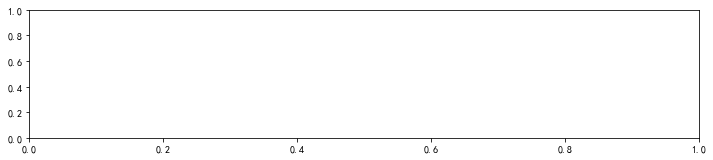

In [27]:
plt.figure(figsize=(12,8))
plt.subplot(311)
sup_water['水厂供水总量'].plot(title='水厂供水总量')
plt.subplot(312)
sup_water['最高温度'].plot(title='最高温度') 
plt.subplot(313)
sup_water['最低温度'].plot(title='最低温度')

In [ ]:
#判断缺失值
# sup_water[sup_water.isnull().any(axis=1)]

# np.isinf(sup_water['最高温度']).value_counts()

#判断数据框里面所有不是有限数据的数，可以排除null，np.nan,np.inf
sup_water[~(np.isfinite(sup_water).all(axis=1))]

In [ ]:
#判断离群值
# print(sup_water['最高温度'].value_counts(dropna=False))
am = sup_water['最高温度'].rolling(window=3,min_periods=0,center=True).mean()
diff = sup_water['最高温度'].values-am

# plt.figure(figsize=(12,8))
# plt.scatter(data = sup_water, x= sup_water.index.values,
#          y = '最低温度', 
#          marker='.',label='最低温度')
# plt.plot(sup_water.index.values,sup_water['上限'],'r--',label='离群上限')
# plt.plot(sup_water.index.values,sup_water['下限'],'r--',label='离群下限')
# plt.legend(loc='best')
# plt.title("动态判断时间序列的离群值")

sup_water.loc[diff.abs()>diff.std(ddof=0)*4,].sort_values('最高温度')

In [ ]:
sup_water.eval("平均温度=(最高温度+最低温度)/2",inplace=True)

In [ ]:
sup_water

**按照多项式处理来看各指标的相关性**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3,include_bias=1)
X_poly = poly_features.fit_transform(sup_water[['最低温度','最高温度','平均温度']])

#将poly数组转化程dataframe画相关矩阵，np也有相关矩阵函数，但带列名更加清楚。
sup_water_poly= pd.DataFrame(data=X_poly,columns=poly_features.get_feature_names())

sup_water_poly['水厂供水总量'] = sup_water['水厂供水总量'].values

sup_water_poly.corrwith(sup_water_poly['水厂供水总量']).sort_values(ascending=False)

**从上面结果来看最高温的相关性最高**

In [ ]:
#pd还提供做相关矩阵和相关性图的函数，但因为指标太多，因此省去。
# sup_water.corr()
# pd.plotting.scatter_matrix(sup_water,figsize=(12,8),alpha=0.2)

## **正式运用模型**

In [ ]:
sup_water_fp=sup_water.reset_index()[['QUOTA_DATE','水厂供水总量','最高温度']].rename(columns={'QUOTA_DATE':'ds','水厂供水总量':'y'})

In [ ]:
# sup_water_fp['y'] = np.log(sup_water_fp['y'])

In [ ]:
# cap = 5050000
# sup_water_fp['cap']= cap

In [ ]:
# import borax

In [ ]:
import sxtwl
lunar = sxtwl.Lunar()


In [ ]:
guoqing = pd.DataFrame({
  'holiday': 'guoqing',
  'ds': pd.date_range(start= '2015-10-1',periods=6,freq='AS-OCT'),
  'lower_window': 0,
  'upper_window': 6,
})

spring_date=[]
for i in list(range(2014,2020)):
    solar_day = lunar.getDayByLunar(i,12,30)
    solar_date = dt.date(solar_day.y, solar_day.m, solar_day.d)
    spring_date.append(solar_date)
    
spring = pd.DataFrame({
  'holiday': 'spring',
  'ds':spring_date,
  'lower_window': -14,
  'upper_window': 14,
})

covid1 = pd.DataFrame({
  'holiday': 'covid1',
  'ds':pd.date_range(start= '2020-1-23',end='2020-2-23'),
  'lower_window': 0,
  'upper_window': 0,
})

covid2 = pd.DataFrame({
  'holiday': 'covid2',
  'ds':pd.date_range(start= '2020-2-24',end='2020-4-7'),
  'lower_window': 0,
  'upper_window': 0,
})

covid3 = pd.DataFrame({
  'holiday': 'covid3',
  'ds':pd.date_range(start= '2020-4-8',end='2020-4-30'),
  'lower_window': 0,
  'upper_window': 0,
})



holidays = pd.concat((guoqing, spring,covid1,covid2,covid3))

In [ ]:
holidays

In [ ]:
sup_water_fp

In [ ]:
#initial=三（10=-1），period=7天，cv=10折，horizon=31天
7*(10-1)+365*2+31+1
# dt.date(2020,4,2)-dt.timedelta(days = 31)

In [ ]:
sup_water_train = sup_water_fp[-825:]
# sup_water_test = sup_water_fp[-31:]

In [37]:
sup_water_train

,ds,y,最高温度
1105,2018-01-10,4378260.0,14.0
1106,2018-01-11,4440317.0,17.0
1107,2018-01-12,4427003.0,16.0
1108,2018-01-13,4398038.0,18.0
1109,2018-01-14,4409975.0,19.0
...,...,...,...
1925,2020-04-09,4339059.0,28.0
1926,2020-04-10,4271948.0,27.0
1927,2020-04-11,4120541.0,24.0
1928,2020-04-12,4260394.0,23.0


In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
# from sklearn.metrics import mean_squared_error

In [29]:
holidays_scale = np.round(np.linspace(0.5,10,5),1)
weekly_scale = np.round(np.linspace(0.5,10,5),1)
yearly_order = np.round(np.linspace(1,10,5),0).astype('int')
yearly_scale = np.round(np.linspace(0.5,10,5),1)
regressor_scale = np.round(np.linspace(1,20,5),1)


import itertools
paramlist = list(itertools.product(holidays_scale,weekly_scale,yearly_order,yearly_scale,regressor_scale ))

In [33]:
import warnings
warnings.filterwarnings("ignore") 
def fun_rmse(df):
            return np.sqrt(np.mean(np.square(df['y']-df['yhat'])))
df1 = pd.DataFrame(columns=('param', 'rmse'))
i = 0
for param in paramlist:
    try:
        m = Prophet(holidays=holidays,
            #n_changepoints = 25,
            #changepoint_range = 0.8 ,
            #changepoint_prior_scale = 0.05,
            holidays_prior_scale=param[0] )
        m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=param[1])
        m.add_seasonality(name='yearly', period=365.25, fourier_order=param[2], prior_scale=param[3])
        m.add_regressor('最高温度',prior_scale=param[4])
        m.fit(sup_water_train)

        df_cv = cross_validation(m, initial='730 days', period='7 days', horizon = '31 days') 
        rmse_ave = df_cv.groupby('cutoff').apply(fun_rmse).mean()
        df1.loc[i] = [param,rmse_ave]   
        i+=1
        print('第{:d}次记录完成'.format(i))
    except:
        continue
df1.sort_values(['rmse']).head(10)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第4次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第5次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第6次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第7次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第8次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第9次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第10次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第11次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第12次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第13次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第14次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第15次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第16次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第17次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第18次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第19次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第20次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第21次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第22次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第23次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第24次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第25次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第26次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第27次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第28次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第29次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第30次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第31次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第32次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第33次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第34次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第35次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第36次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第37次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第38次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第39次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第40次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第41次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第42次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第43次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第44次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第45次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第46次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第47次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第48次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第49次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第50次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第51次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第52次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第53次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第54次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第55次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第56次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第57次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第58次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第59次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第60次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第61次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第62次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第63次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第64次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第65次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第66次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第67次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第68次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第69次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第70次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第71次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第72次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第73次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第74次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第75次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第76次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第77次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第78次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第79次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第80次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第81次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第82次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第83次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第84次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第85次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第86次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第87次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第88次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第89次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第90次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第91次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第92次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第93次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第94次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第95次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第96次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第97次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第98次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第99次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第100次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第101次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第102次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第103次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第104次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第105次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第106次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第107次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第108次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第109次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第110次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第111次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第112次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第113次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第114次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第115次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第116次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第117次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第118次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第119次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第120次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第121次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第122次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第123次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第124次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第125次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第126次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第127次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第128次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第129次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第130次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第131次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第132次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第133次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第134次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第135次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第136次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第137次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第138次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第139次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第140次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第141次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第142次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第143次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第144次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第145次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第146次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第147次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第148次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第149次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第150次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第151次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第152次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第153次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第154次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第155次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第156次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第157次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第158次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第159次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第160次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第161次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第162次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第163次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第164次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第165次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第166次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第167次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第168次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第169次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第170次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第171次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第172次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第173次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第174次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第175次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第176次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第177次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第178次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第179次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第180次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第181次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第182次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第183次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第184次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第185次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第186次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第187次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第188次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第189次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第190次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第191次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第192次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第193次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第194次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第195次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第196次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第197次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第198次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第199次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第200次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第201次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第202次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第203次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第204次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第205次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第206次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第207次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第208次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第209次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第210次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第211次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第212次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第213次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第214次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第215次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第216次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第217次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第218次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第219次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第220次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第221次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第222次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第223次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第224次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第225次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第226次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第227次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第228次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第229次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第230次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第231次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第232次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第233次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第234次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第235次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第236次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第237次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第238次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第239次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第240次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第241次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第242次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第243次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第244次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第245次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第246次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第247次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第248次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第249次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第250次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第251次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第252次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第253次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第254次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第255次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第256次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第257次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第258次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第259次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第260次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第261次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第262次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第263次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第264次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第265次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第266次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第267次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第268次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第269次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第270次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第271次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第272次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第273次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第274次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第275次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第276次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第277次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第278次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第279次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第280次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第281次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第282次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第283次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第284次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第285次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第286次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第287次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第288次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第289次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第290次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第291次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第292次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第293次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第294次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第295次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第296次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第297次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第298次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第299次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第300次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第301次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第302次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第303次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第304次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第305次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第306次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第307次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第308次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第309次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第310次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第311次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第312次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第313次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第314次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第315次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第316次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第317次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第318次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第319次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第320次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第321次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第322次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第323次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第324次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第325次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第326次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第327次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第328次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第329次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第330次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第331次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第332次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第333次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第334次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第335次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第336次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第337次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第338次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第339次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第340次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第341次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第342次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第343次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第344次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第345次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第346次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第347次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第348次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第349次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第350次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第351次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第352次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第353次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第354次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第355次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第356次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第357次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第358次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第359次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第360次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第361次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第362次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第363次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第364次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第365次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第366次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第367次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第368次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第369次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第370次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第371次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第372次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第373次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第374次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第375次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第376次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第377次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第378次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第379次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第380次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第381次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第382次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第383次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第384次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第385次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第386次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第387次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第388次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第389次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第390次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第391次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第392次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第393次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第394次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00


第395次记录完成


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第396次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第397次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第398次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第399次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第400次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第401次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第402次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第403次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第404次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第405次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第406次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第407次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第408次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第409次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第410次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第411次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第412次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第413次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第414次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第415次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第416次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第417次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第418次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第419次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第420次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第421次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第422次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第423次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第424次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第425次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第426次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第427次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第428次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第429次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第430次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第431次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第432次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第433次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第434次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第435次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第436次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第437次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第438次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第439次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第440次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第441次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第442次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第443次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第444次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第445次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第446次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第447次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第448次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第449次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第450次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第451次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第452次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第453次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第454次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第455次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第456次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第457次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第458次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第459次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第460次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第461次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第462次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第463次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第464次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第465次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第466次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第467次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第468次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第469次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第470次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第471次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第472次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第473次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第474次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第475次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第476次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第477次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第478次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第479次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第480次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第481次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第482次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第483次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第484次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第485次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第486次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第487次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第488次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第489次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第490次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第491次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第492次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第493次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第494次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第495次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第496次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第497次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第498次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第499次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第500次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第501次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第502次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第503次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第504次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第505次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第506次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第507次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第508次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第509次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第510次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第511次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第512次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第513次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第514次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第515次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第516次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第517次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第518次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第519次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第520次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第521次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第522次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第523次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第524次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第525次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第526次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第527次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第528次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第529次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第530次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第531次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第532次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第533次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第534次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第535次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第536次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第537次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第538次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第539次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第540次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第541次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第542次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第543次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第544次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第545次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第546次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第547次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第548次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第549次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第550次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第551次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第552次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第553次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第554次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第555次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第556次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第557次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第558次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第559次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第560次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第561次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第562次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第563次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第564次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第565次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第566次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第567次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第568次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第569次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第570次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第571次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第572次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第573次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第574次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第575次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第576次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第577次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第578次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第579次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第580次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第581次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第582次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第583次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第584次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第585次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第586次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第587次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第588次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第589次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第590次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第591次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第592次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第593次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第594次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第595次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第596次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第597次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第598次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第599次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第600次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第601次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第602次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第603次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第604次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第605次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第606次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第607次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第608次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第609次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第610次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第611次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第612次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第613次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第614次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第615次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第616次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第617次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第618次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第619次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第620次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第621次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第622次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第623次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第624次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第625次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第626次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第627次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第628次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第629次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第630次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第631次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第632次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第633次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第634次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第635次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第636次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第637次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第638次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第639次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第640次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第641次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第642次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第643次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第644次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第645次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第646次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第647次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第648次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第649次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第650次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第651次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第652次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第653次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第654次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第655次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第656次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第657次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第658次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第659次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第660次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第661次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第662次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第663次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第664次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第665次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第666次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第667次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第668次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第669次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第670次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第671次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第672次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第673次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第674次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第675次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第676次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第677次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第678次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第679次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第680次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第681次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第682次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第683次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第684次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第685次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第686次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第687次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第688次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第689次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第690次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第691次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第692次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第693次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第694次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第695次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第696次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第697次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第698次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第699次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第700次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第701次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第702次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第703次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第704次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第705次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第706次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第707次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第708次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第709次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第710次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第711次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第712次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第713次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第714次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第715次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第716次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第717次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第718次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第719次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第720次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第721次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第722次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第723次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第724次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第725次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第726次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第727次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第728次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第729次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第730次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第731次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第732次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第733次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第734次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第735次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第736次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第737次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第738次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第739次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第740次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第741次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第742次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第743次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第744次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第745次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第746次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第747次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第748次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第749次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第750次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第751次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第752次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第753次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第754次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第755次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第756次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第757次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第758次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第759次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第760次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第761次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第762次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第763次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第764次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第765次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第766次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第767次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第768次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第769次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第770次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第771次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第772次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第773次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第774次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第775次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第776次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第777次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第778次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第779次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第780次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第781次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第782次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第783次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第784次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第785次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第786次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第787次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第788次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第789次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第790次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第791次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第792次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第793次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第794次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第795次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第796次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第797次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第798次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第799次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第800次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第801次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第802次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第803次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第804次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第805次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第806次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第807次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第808次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第809次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第810次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第811次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第812次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第813次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第814次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第815次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第816次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第817次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第818次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第819次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第820次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第821次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第822次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第823次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第824次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第825次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第826次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第827次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第828次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第829次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第830次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第831次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第832次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第833次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第834次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第835次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第836次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第837次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第838次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第839次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第840次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第841次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第842次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第843次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第844次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第845次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第846次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第847次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第848次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第849次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第850次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第851次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第852次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第853次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第854次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第855次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第856次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第857次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第858次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第859次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第860次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第861次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第862次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第863次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第864次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第865次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第866次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第867次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第868次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第869次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第870次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第871次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第872次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第873次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第874次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第875次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第876次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第877次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第878次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第879次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第880次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第881次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第882次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第883次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第884次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第885次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第886次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第887次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第888次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第889次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第890次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第891次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第892次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第893次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第894次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第895次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第896次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第897次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第898次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第899次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第900次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第901次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第902次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第903次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第904次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第905次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第906次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第907次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第908次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第909次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第910次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第911次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第912次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第913次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第914次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第915次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第916次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第917次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第918次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第919次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第920次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第921次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第922次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第923次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第924次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第925次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第926次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第927次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第928次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第929次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第930次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第931次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第932次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第933次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第934次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第935次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第936次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第937次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第938次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第939次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第940次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第941次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第942次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第943次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第944次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第945次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第946次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第947次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第948次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第949次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第950次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第951次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第952次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第953次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第954次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第955次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第956次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第957次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第958次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第959次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第960次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第961次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第962次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第963次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第964次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第965次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第966次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第967次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第968次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第969次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第970次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第971次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第972次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第973次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第974次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第975次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第976次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第977次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第978次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第979次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第980次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第981次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第982次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第983次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第984次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第985次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第986次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第987次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第988次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第989次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第990次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第991次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第992次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第993次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第994次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第995次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第996次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第997次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第998次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第999次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1000次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1001次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1002次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1003次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1004次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1005次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1006次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1007次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1008次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1009次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1010次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1011次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1012次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1013次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1014次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1015次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1016次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1017次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1018次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1019次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1020次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1021次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1022次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1023次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1024次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1025次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1026次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1027次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1028次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1029次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1030次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1031次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1032次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1033次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1034次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1035次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1036次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1037次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1038次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1039次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1040次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1041次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1042次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1043次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1044次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1045次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1046次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1047次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1048次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1049次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1050次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1051次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1052次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1053次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1054次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1055次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1056次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1057次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1058次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1059次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1060次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1061次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1062次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1063次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1064次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1065次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1066次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1067次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1068次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1069次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1070次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1071次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1072次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1073次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1074次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1075次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1076次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1077次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1078次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1079次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1080次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1081次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1082次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1083次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1084次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1085次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1086次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1087次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1088次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1089次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1090次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1091次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1092次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1093次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1094次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1095次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1096次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1097次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1098次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1099次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1100次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1101次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1102次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1103次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1104次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1105次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1106次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1107次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1108次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1109次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1110次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1111次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1112次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1113次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1114次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1115次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1116次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1117次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1118次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1119次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1120次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1121次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1122次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1123次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1124次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1125次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1126次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1127次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1128次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1129次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1130次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1131次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1132次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1133次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1134次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1135次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1136次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1137次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1138次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1139次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1140次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1141次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1142次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1143次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1144次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1145次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1146次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1147次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1148次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1149次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1150次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1151次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1152次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1153次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1154次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1155次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1156次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1157次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1158次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1159次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1160次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1161次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1162次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1163次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1164次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1165次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1166次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1167次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1168次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1169次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1170次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1171次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1172次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1173次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1174次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1175次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1176次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1177次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1178次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1179次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1180次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1181次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1182次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1183次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1184次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1185次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1186次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1187次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1188次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1189次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1190次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1191次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1192次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1193次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1194次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1195次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1196次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1197次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1198次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1199次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1200次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1201次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1202次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1203次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1204次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1205次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1206次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1207次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1208次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1209次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1210次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1211次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1212次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1213次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1214次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1215次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1216次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1217次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1218次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1219次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1220次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1221次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1222次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1223次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1224次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1225次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1226次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1227次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1228次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1229次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1230次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1231次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1232次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1233次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1234次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1235次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1236次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1237次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1238次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1239次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1240次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1241次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1242次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1243次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1244次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1245次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1246次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1247次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1248次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1249次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1250次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1251次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1252次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1253次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1254次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1255次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1256次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1257次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1258次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1259次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1260次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1261次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1262次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1263次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1264次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1265次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1266次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1267次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1268次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1269次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1270次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1271次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1272次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1273次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1274次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1275次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1276次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1277次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1278次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1279次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1280次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1281次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1282次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1283次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1284次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1285次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1286次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1287次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1288次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1289次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1290次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1291次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1292次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1293次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1294次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1295次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1296次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1297次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1298次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1299次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1300次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1301次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1302次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1303次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1304次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1305次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1306次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1307次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1308次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1309次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1310次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1311次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1312次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1313次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1314次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1315次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1316次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1317次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1318次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1319次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1320次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1321次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1322次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1323次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1324次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1325次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1326次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1327次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1328次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1329次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1330次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1331次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1332次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1333次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1334次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1335次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1336次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1337次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1338次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1339次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1340次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1341次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1342次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1343次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1344次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1345次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1346次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1347次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1348次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1349次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1350次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1351次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1352次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1353次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1354次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1355次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1356次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1357次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1358次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1359次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1360次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1361次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1362次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1363次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1364次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1365次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1366次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1367次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1368次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1369次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1370次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1371次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1372次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1373次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1374次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1375次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1376次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1377次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1378次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1379次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1380次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1381次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1382次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1383次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1384次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1385次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1386次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1387次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1388次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1389次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1390次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1391次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1392次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1393次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1394次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1395次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1396次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1397次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1398次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1399次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1400次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1401次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1402次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1403次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1404次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1405次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1406次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1407次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1408次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1409次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1410次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1411次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1412次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1413次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1414次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1415次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1416次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1417次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1418次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1419次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1420次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1421次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1422次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1423次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1424次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1425次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1426次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1427次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1428次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1429次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1430次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1431次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1432次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1433次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1434次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1435次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1436次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1437次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1438次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1439次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1440次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1441次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1442次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1443次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1444次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1445次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1446次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1447次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1448次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1449次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1450次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1451次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1452次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1453次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1454次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1455次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1456次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1457次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1458次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1459次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1460次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1461次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1462次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1463次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1464次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1465次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1466次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1467次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1468次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1469次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1470次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1471次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1472次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1473次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1474次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1475次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1476次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1477次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1478次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1479次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1480次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1481次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1482次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1483次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1484次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1485次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1486次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1487次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1488次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1489次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1490次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1491次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1492次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1493次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1494次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1495次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1496次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1497次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1498次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1499次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1500次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1501次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1502次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1503次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1504次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1505次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1506次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1507次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1508次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1509次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1510次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1511次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1512次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1513次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1514次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1515次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1516次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1517次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1518次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1519次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1520次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1521次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1522次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1523次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1524次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1525次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1526次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1527次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1528次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1529次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1530次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1531次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1532次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1533次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1534次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1535次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1536次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1537次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1538次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1539次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1540次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1541次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1542次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1543次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1544次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1545次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1546次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1547次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1548次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1549次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1550次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1551次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1552次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1553次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1554次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1555次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1556次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1557次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1558次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1559次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1560次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1561次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1562次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1563次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1564次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1565次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1566次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1567次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1568次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1569次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1570次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1571次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1572次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1573次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1574次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1575次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1576次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1577次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1578次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1579次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1580次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1581次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1582次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1583次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1584次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1585次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1586次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1587次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1588次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1589次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1590次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1591次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1592次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1593次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1594次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1595次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1596次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1597次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1598次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1599次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1600次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1601次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1602次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1603次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1604次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1605次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1606次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1607次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1608次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1609次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1610次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1611次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1612次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1613次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1614次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1615次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1616次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1617次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1618次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1619次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1620次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1621次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1622次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1623次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1624次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1625次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1626次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1627次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1628次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1629次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1630次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1631次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1632次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1633次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1634次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1635次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1636次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1637次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1638次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1639次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1640次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1641次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1642次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1643次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1644次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1645次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1646次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1647次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1648次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1649次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1650次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1651次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1652次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1653次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1654次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1655次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1656次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1657次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1658次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1659次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1660次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1661次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1662次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1663次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1664次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1665次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1666次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1667次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1668次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1669次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1670次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1671次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1672次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1673次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1674次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1675次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1676次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1677次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1678次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1679次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1680次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1681次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1682次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1683次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1684次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1685次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1686次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1687次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1688次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1689次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1690次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1691次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1692次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1693次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1694次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1695次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1696次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1697次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1698次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1699次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1700次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1701次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1702次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1703次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1704次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1705次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1706次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1707次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1708次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1709次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1710次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1711次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1712次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1713次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1714次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1715次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1716次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1717次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1718次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1719次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1720次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1721次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1722次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1723次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1724次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1725次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1726次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1727次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1728次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1729次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1730次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1731次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1732次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1733次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1734次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1735次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1736次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1737次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1738次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1739次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1740次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1741次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1742次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1743次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1744次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1745次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1746次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1747次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1748次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1749次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1750次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1751次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1752次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1753次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1754次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1755次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1756次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1757次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1758次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1759次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1760次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1761次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1762次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1763次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1764次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1765次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1766次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1767次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1768次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1769次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1770次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1771次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1772次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1773次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1774次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1775次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1776次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1777次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1778次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1779次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1780次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1781次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1782次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1783次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1784次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1785次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1786次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1787次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1788次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1789次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1790次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1791次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1792次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1793次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1794次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1795次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1796次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1797次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1798次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1799次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1800次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1801次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1802次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1803次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1804次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1805次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1806次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1807次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1808次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1809次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1810次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1811次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1812次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1813次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1814次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1815次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1816次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1817次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1818次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1819次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1820次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1821次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1822次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1823次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1824次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1825次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1826次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1827次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1828次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1829次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1830次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1831次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1832次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1833次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1834次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1835次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1836次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1837次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1838次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1839次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1840次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1841次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1842次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1843次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1844次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1845次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1846次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1847次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1848次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1849次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1850次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1851次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1852次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1853次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1854次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1855次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1856次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1857次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1858次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1859次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1860次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1861次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1862次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1863次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1864次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1865次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1866次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1867次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1868次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1869次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1870次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1871次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1872次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1873次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1874次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1875次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1876次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1877次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1878次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1879次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1880次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1881次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1882次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1883次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1884次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1885次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1886次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1887次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1888次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1889次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1890次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1891次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1892次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1893次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1894次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1895次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1896次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1897次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1898次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1899次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1900次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1901次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1902次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1903次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1904次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1905次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1906次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1907次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1908次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1909次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1910次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1911次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1912次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1913次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1914次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1915次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1916次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1917次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1918次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1919次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1920次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1921次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1922次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1923次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1924次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1925次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1926次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1927次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1928次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1929次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1930次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1931次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1932次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1933次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1934次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1935次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1936次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1937次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1938次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1939次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1940次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1941次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1942次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1943次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1944次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1945次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1946次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1947次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1948次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1949次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1950次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1951次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1952次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1953次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1954次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1955次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1956次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1957次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1958次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1959次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1960次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1961次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1962次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1963次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1964次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1965次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1966次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1967次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1968次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1969次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1970次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1971次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1972次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1973次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1974次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1975次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1976次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1977次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1978次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1979次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1980次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1981次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1982次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1983次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1984次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1985次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1986次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1987次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1988次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1989次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1990次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1991次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1992次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1993次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1994次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1995次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1996次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1997次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1998次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1999次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2000次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2001次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2002次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2003次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2004次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2005次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2006次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2007次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2008次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2009次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2010次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2011次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2012次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2013次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2014次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2015次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2016次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2017次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2018次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2019次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2020次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2021次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2022次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2023次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2024次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2025次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2026次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2027次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2028次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2029次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2030次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2031次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2032次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2033次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2034次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2035次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2036次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2037次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2038次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2039次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2040次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2041次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2042次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2043次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2044次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2045次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2046次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2047次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2048次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2049次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2050次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2051次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2052次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2053次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2054次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2055次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2056次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2057次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2058次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2059次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2060次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2061次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2062次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2063次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2064次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2065次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2066次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2067次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2068次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2069次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2070次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2071次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2072次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2073次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2074次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2075次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2076次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2077次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2078次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2079次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2080次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2081次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2082次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2083次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2084次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2085次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2086次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2087次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2088次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2089次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2090次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2091次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2092次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2093次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2094次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2095次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2096次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2097次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2098次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2099次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2100次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2101次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2102次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2103次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2104次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2105次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2106次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2107次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2108次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2109次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2110次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2111次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2112次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2113次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2114次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2115次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2116次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2117次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2118次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2119次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2120次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2121次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2122次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2123次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2124次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2125次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2126次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2127次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2128次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2129次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2130次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2131次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2132次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2133次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2134次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2135次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2136次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2137次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2138次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2139次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2140次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2141次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2142次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2143次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2144次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2145次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2146次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2147次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2148次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2149次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2150次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2151次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2152次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2153次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2154次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2155次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2156次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2157次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2158次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2159次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2160次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2161次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2162次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2163次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2164次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2165次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2166次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2167次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2168次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2169次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2170次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2171次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2172次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2173次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2174次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2175次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2176次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2177次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2178次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2179次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2180次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2181次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2182次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2183次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2184次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2185次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2186次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2187次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2188次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2189次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2190次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2191次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2192次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2193次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2194次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2195次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2196次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2197次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2198次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2199次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2200次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2201次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2202次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2203次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2204次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2205次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2206次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2207次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2208次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2209次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2210次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2211次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2212次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2213次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2214次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2215次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2216次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2217次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2218次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2219次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2220次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2221次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2222次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2223次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2224次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2225次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2226次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2227次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2228次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2229次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2230次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2231次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2232次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2233次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2234次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2235次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2236次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2237次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2238次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2239次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2240次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2241次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2242次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2243次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2244次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2245次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2246次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2247次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2248次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2249次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2250次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2251次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2252次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2253次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2254次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2255次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2256次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2257次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2258次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2259次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2260次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2261次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2262次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2263次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2264次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2265次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2266次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2267次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2268次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2269次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2270次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2271次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2272次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2273次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2274次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2275次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2276次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2277次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2278次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2279次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2280次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2281次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2282次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2283次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2284次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2285次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2286次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2287次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2288次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2289次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2290次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2291次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2292次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2293次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2294次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2295次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2296次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2297次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2298次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2299次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2300次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2301次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2302次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2303次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2304次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2305次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2306次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2307次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2308次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2309次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2310次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2311次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2312次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2313次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2314次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2315次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2316次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2317次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2318次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2319次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2320次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2321次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2322次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2323次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2324次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2325次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2326次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2327次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2328次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2329次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2330次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2331次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2332次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2333次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2334次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2335次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2336次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2337次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2338次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2339次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2340次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2341次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2342次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2343次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2344次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2345次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2346次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2347次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2348次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2349次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2350次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2351次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2352次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2353次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2354次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2355次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2356次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2357次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2358次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2359次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2360次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2361次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2362次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2363次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2364次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2365次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2366次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2367次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2368次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2369次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2370次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2371次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2372次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2373次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2374次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2375次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2376次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2377次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2378次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2379次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2380次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2381次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2382次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2383次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2384次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2385次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2386次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2387次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2388次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2389次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2390次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2391次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2392次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2393次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2394次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2395次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2396次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2397次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2398次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2399次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2400次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2401次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2402次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2403次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2404次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2405次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2406次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2407次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2408次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2409次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2410次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2411次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2412次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2413次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2414次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2415次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2416次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2417次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2418次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2419次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2420次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2421次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2422次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2423次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2424次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2425次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2426次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2427次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2428次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2429次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2430次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2431次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2432次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2433次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2434次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2435次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2436次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2437次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2438次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2439次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2440次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2441次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2442次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2443次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2444次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2445次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2446次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2447次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2448次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2449次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2450次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2451次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2452次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2453次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2454次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2455次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2456次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2457次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2458次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2459次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2460次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2461次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2462次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2463次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2464次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2465次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2466次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2467次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2468次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2469次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2470次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2471次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2472次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2473次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2474次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2475次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2476次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2477次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2478次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2479次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2480次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2481次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2482次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2483次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2484次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2485次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2486次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2487次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2488次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2489次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2490次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2491次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2492次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2493次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2494次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2495次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2496次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2497次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2498次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2499次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2500次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2501次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2502次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2503次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2504次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2505次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2506次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2507次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2508次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2509次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2510次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2511次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2512次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2513次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2514次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2515次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2516次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2517次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2518次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2519次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2520次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2521次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2522次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2523次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2524次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2525次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2526次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2527次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2528次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2529次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2530次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2531次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2532次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2533次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2534次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2535次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2536次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2537次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2538次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2539次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2540次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2541次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2542次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2543次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2544次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2545次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2546次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2547次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2548次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2549次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2550次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2551次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2552次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2553次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2554次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2555次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2556次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2557次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2558次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2559次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2560次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2561次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2562次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2563次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2564次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2565次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2566次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2567次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2568次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2569次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2570次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2571次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2572次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2573次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2574次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2575次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2576次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2577次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2578次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2579次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2580次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2581次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2582次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2583次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2584次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2585次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2586次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2587次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2588次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2589次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2590次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2591次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2592次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2593次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2594次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2595次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2596次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2597次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2598次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2599次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2600次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2601次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2602次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2603次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2604次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2605次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2606次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2607次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2608次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2609次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2610次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2611次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2612次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2613次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2614次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2615次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2616次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2617次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2618次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2619次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2620次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2621次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2622次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2623次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2624次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2625次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2626次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2627次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2628次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2629次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2630次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2631次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2632次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2633次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2634次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2635次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2636次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2637次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2638次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2639次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2640次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2641次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2642次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2643次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2644次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2645次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2646次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2647次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2648次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2649次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2650次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2651次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2652次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2653次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2654次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2655次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2656次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2657次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2658次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2659次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2660次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2661次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2662次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2663次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2664次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2665次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2666次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2667次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2668次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2669次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2670次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2671次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2672次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2673次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2674次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2675次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2676次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2677次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2678次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2679次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2680次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2681次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2682次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2683次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2684次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2685次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2686次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2687次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2688次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2689次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2690次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2691次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2692次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2693次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2694次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2695次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2696次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2697次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2698次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2699次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2700次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2701次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2702次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2703次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2704次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2705次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2706次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2707次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2708次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2709次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2710次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2711次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2712次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2713次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2714次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2715次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2716次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2717次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2718次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2719次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2720次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2721次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2722次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2723次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2724次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2725次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2726次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2727次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2728次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2729次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2730次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2731次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2732次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2733次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2734次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2735次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2736次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2737次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2738次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2739次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2740次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2741次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2742次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2743次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2744次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2745次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2746次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2747次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2748次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2749次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2750次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2751次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2752次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2753次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2754次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2755次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2756次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2757次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2758次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2759次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2760次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2761次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2762次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2763次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2764次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2765次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2766次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2767次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2768次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2769次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2770次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2771次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2772次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2773次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2774次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2775次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2776次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2777次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2778次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2779次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2780次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2781次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2782次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2783次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2784次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2785次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2786次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2787次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2788次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2789次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2790次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2791次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2792次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2793次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2794次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2795次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2796次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2797次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2798次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2799次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2800次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2801次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2802次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2803次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2804次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2805次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2806次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2807次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2808次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2809次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2810次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2811次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2812次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2813次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2814次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2815次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2816次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2817次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2818次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2819次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2820次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2821次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2822次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2823次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2824次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2825次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2826次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2827次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2828次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2829次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2830次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2831次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2832次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2833次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2834次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2835次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2836次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2837次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2838次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2839次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2840次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2841次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2842次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2843次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2844次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2845次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2846次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2847次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2848次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2849次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2850次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2851次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2852次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2853次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2854次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2855次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2856次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2857次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2858次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2859次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2860次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2861次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2862次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2863次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2864次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2865次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2866次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2867次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2868次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2869次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2870次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2871次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2872次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2873次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2874次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2875次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2876次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2877次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2878次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2879次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2880次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2881次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2882次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2883次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2884次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2885次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2886次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2887次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2888次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2889次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2890次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2891次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2892次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2893次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2894次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2895次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2896次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2897次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2898次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2899次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2900次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2901次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2902次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2903次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2904次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2905次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2906次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2907次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2908次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2909次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2910次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2911次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2912次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2913次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2914次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2915次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2916次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2917次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2918次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2919次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2920次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2921次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2922次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2923次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2924次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2925次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2926次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2927次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2928次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2929次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2930次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2931次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2932次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2933次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2934次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2935次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2936次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2937次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2938次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2939次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2940次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2941次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2942次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2943次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2944次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2945次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2946次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2947次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2948次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2949次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2950次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2951次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2952次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2953次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2954次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2955次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2956次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2957次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2958次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2959次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2960次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2961次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2962次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2963次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2964次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2965次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2966次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2967次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2968次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2969次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2970次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2971次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2972次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2973次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2974次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2975次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2976次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2977次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2978次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2979次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2980次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2981次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2982次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2983次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2984次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2985次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2986次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2987次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2988次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2989次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2990次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2991次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2992次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2993次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2994次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2995次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2996次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2997次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2998次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2999次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3000次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3001次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3002次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3003次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3004次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3005次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3006次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3007次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3008次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3009次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3010次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3011次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3012次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3013次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3014次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3015次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3016次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3017次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3018次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3019次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3020次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3021次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3022次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3023次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3024次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3025次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3026次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3027次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3028次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3029次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3030次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3031次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3032次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3033次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3034次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3035次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3036次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3037次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3038次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3039次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3040次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3041次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3042次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3043次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3044次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3045次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3046次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3047次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3048次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3049次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3050次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3051次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3052次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3053次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3054次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3055次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3056次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3057次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3058次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3059次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3060次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3061次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3062次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3063次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3064次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3065次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3066次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3067次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3068次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3069次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3070次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3071次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3072次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3073次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3074次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3075次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3076次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3077次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3078次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3079次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3080次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3081次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3082次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3083次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3084次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3085次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3086次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3087次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3088次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3089次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3090次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3091次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3092次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3093次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3094次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3095次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3096次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3097次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3098次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3099次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3100次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3101次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3102次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3103次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3104次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3105次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3106次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3107次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3108次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3109次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3110次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3111次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3112次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3113次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3114次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3115次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3116次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3117次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3118次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3119次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3120次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3121次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3122次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3123次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3124次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-10 00:00:00 and 2020-03-13 00:00:00


第3125次记录完成


,param,rmse
1680,"(5.2, 7.6, 6, 2.9, 1.0)",256140.797385
2302,"(7.6, 7.6, 6, 0.5, 10.5)",256298.257078
432,"(0.5, 7.6, 6, 2.9, 10.5)",256763.857627
1687,"(5.2, 7.6, 6, 5.2, 10.5)",256836.311568
1564,"(5.2, 5.2, 6, 5.2, 20.0)",257160.984093
1051,"(2.9, 7.6, 6, 0.5, 5.8)",257186.041621
1328,"(5.2, 0.5, 8, 0.5, 15.2)",257199.433249
2304,"(7.6, 7.6, 6, 0.5, 20.0)",257639.204616
2827,"(10.0, 5.2, 8, 0.5, 10.5)",257758.048477
701,"(2.9, 0.5, 8, 0.5, 5.8)",258167.371441


In [ ]:
#随机搜索
# import warnings
# warnings.filterwarnings("ignore") 
# def fun_rmse(df):
#             return np.sqrt(np.mean(np.square(df['y']-df['yhat'])))
# df1 = pd.DataFrame(columns=('param',  'rmse'))
# i = 0
# while i < 200:
#     i+=1
#     print('第{:d}次计算'.format(i))
#     try:
#         # 参数搜索
#         changepoint_range = 0.8 
#         changepoint_prior_scale = 0.05
#         holidays_prior_scale = round(np.random.uniform(0.1,10.1),1)
#         yearly_fourier_order = np.random.randint(1,11)
#         weekly_prior_scale = round(np.random.uniform(0.1,10.1),1)
#         yearly_prior_scale = round(np.random.uniform(0.1,10.1),1)
#         regressor_prior_scale = round(np.random.uniform(0.1,10.1),1)
#         param={'ch_range':changepoint_range,'ch_ps':changepoint_prior_scale,'holi_ps':holidays_prior_scale,
#                       'weekly_ps':weekly_prior_scale,'yearly_forder':yearly_fourier_order,'yearly_ps':yearly_prior_scale,
#                       'regressor_ps':regressor_prior_scale}
#         m = Prophet(holidays=holidays,
#             n_changepoints = 25,
#             changepoint_range=changepoint_range,
#             changepoint_prior_scale=changepoint_prior_scale,
#             holidays_prior_scale=holidays_prior_scale)
#         m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=weekly_prior_scale)
#         m.add_seasonality(name='yearly', period=365.25, fourier_order=yearly_fourier_order, prior_scale=yearly_prior_scale)
#         m.add_regressor('最高温度',prior_scale=regressor_prior_scale)
#         m.fit(sup_water_train)

#         df_cv = cross_validation(m, initial='1095 days', period='7 days', horizon = '31 days') 
#         rmse_ave = df_cv.groupby('cutoff').apply(fun_rmse).mean()
#         df1.loc[i-1] = [param,rmse_ave]                  
#     except:
#         continue

In [36]:
df1.to_excel('param.xls')

In [34]:
df1 = df1.sort_values(['rmse']).head(10)    

In [35]:
for param,rmse in zip(df1['param'],df1['rmse']):
    print(param,rmse)


(5.2, 7.6, 6, 2.9, 1.0) 256140.79738523084
(7.6, 7.6, 6, 0.5, 10.5) 256298.2570778716
(0.5, 7.6, 6, 2.9, 10.5) 256763.85762660726
(5.2, 7.6, 6, 5.2, 10.5) 256836.3115684119
(5.2, 5.2, 6, 5.2, 20.0) 257160.9840926744
(2.9, 7.6, 6, 0.5, 5.8) 257186.04162090312
(5.2, 0.5, 8, 0.5, 15.2) 257199.43324902264
(7.6, 7.6, 6, 0.5, 20.0) 257639.2046161517
(10.0, 5.2, 8, 0.5, 10.5) 257758.04847692372
(2.9, 0.5, 8, 0.5, 5.8) 258167.37144110864


In [86]:
m = Prophet(holidays=holidays,
    n_changepoints = 25,
    changepoint_range = 0.8 ,
    changepoint_prior_scale = 0.05,
    holidays_prior_scale=10)
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=10)
m.add_seasonality(name='yearly', period=365.25, fourier_order=1, prior_scale=10)
m.add_regressor('最高温度',prior_scale=20)
sup_water_train = sup_water_train[-730:]
m.fit(sup_water_train)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# #交叉验证
# from fbprophet.diagnostics import cross_validation
# from sklearn.metrics import mean_squared_error
# df_cv = cross_validation(m, initial='1095 days', period='7 days', horizon = '31 days')
# # df_cv[['yhat','yhat_lower','yhat_upper','y']] = np.exp(df_cv[['yhat','yhat_lower','yhat_upper','y']])

# def rmse(df):
#     return np.sqrt(mean_squared_error(df['y'],df['yhat']))

# df_cv.groupby('cutoff').apply(rmse).mean()

In [ ]:
# help(Prophet)

In [51]:
# m.changepoints_t

array([0.03616484, 0.07232969, 0.10765349, 0.14381833, 0.17998318,
       0.21614802, 0.25231287, 0.28763667, 0.32380151, 0.35996636,
       0.3961312 , 0.43229605, 0.46761985, 0.50378469, 0.53994954,
       0.57611438, 0.61227923, 0.64760303, 0.68376787, 0.71993272,
       0.75609756, 0.79226241, 0.82758621, 0.86375105, 0.8999159 ])

In [ ]:
# df_cv.query("cutoff ==  '2020-03-02'")

In [ ]:
# from fbprophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv)
# df_p

In [41]:
future = m.make_future_dataframe(periods=17,freq = 'd',
                                 include_history = False)
future 

,ds
0,2020-04-14
1,2020-04-15
2,2020-04-16
3,2020-04-17
4,2020-04-18
5,2020-04-19
6,2020-04-20
7,2020-04-21
8,2020-04-22
9,2020-04-23


In [42]:
# future['cap'] = cap
future['最高温度'] = [23,25,27,28,28,
                      28,29,27,21,20,
                      19,18,21,23,28,
                      28,28]
future = sup_water_train[['ds','最高温度']].append(future,ignore_index=True)

In [43]:
print(future)

            ds  最高温度
0   2018-04-15  19.0
1   2018-04-16  17.0
2   2018-04-17  25.0
3   2018-04-18  27.0
4   2018-04-19  26.0
..         ...   ...
742 2020-04-26  21.0
743 2020-04-27  23.0
744 2020-04-28  28.0
745 2020-04-29  28.0
746 2020-04-30  28.0

[747 rows x 2 columns]


In [87]:
forecast = m.predict(future)

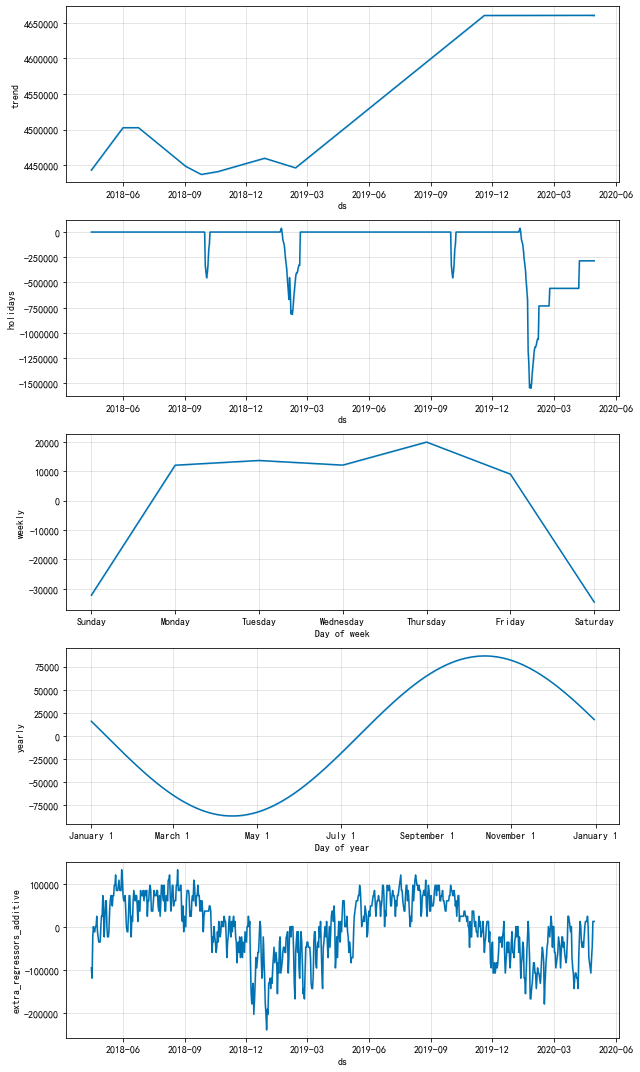

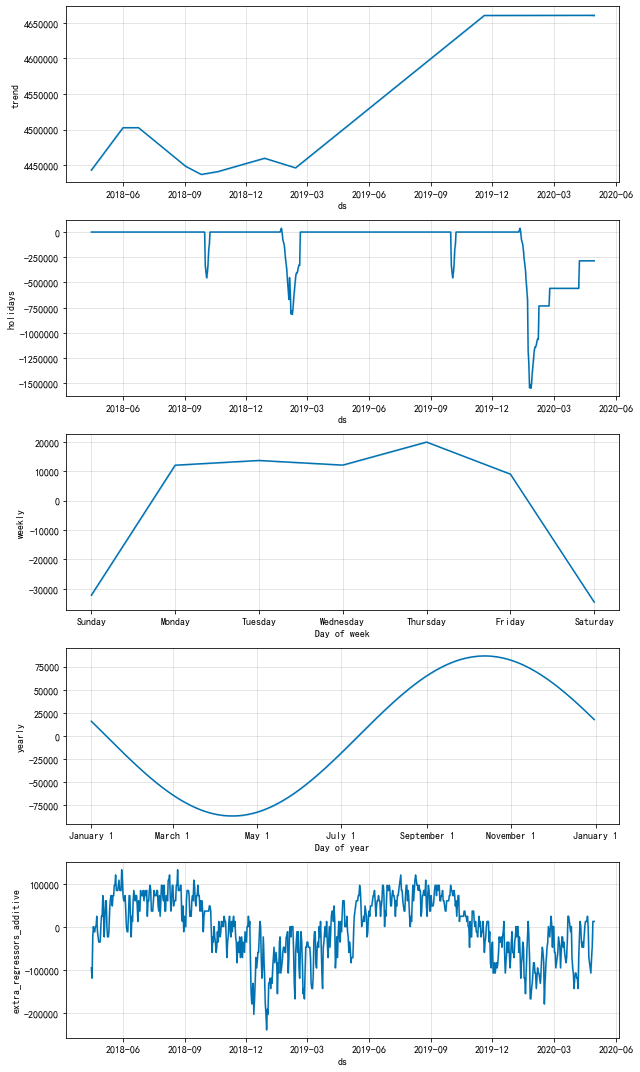

In [88]:
m.plot_components(forecast)

In [89]:
forecast.tail(17)[['ds','yhat']]

,ds,yhat
730,2020-04-14,4.255371e+06
731,2020-04-15,4.277888e+06
732,2020-04-16,4.309839e+06
733,2020-04-17,4.311058e+06
734,2020-04-18,4.267638e+06
735,2020-04-19,4.270138e+06
736,2020-04-20,4.326560e+06
737,2020-04-21,4.304316e+06
738,2020-04-22,4.230814e+06
739,2020-04-23,4.226869e+06


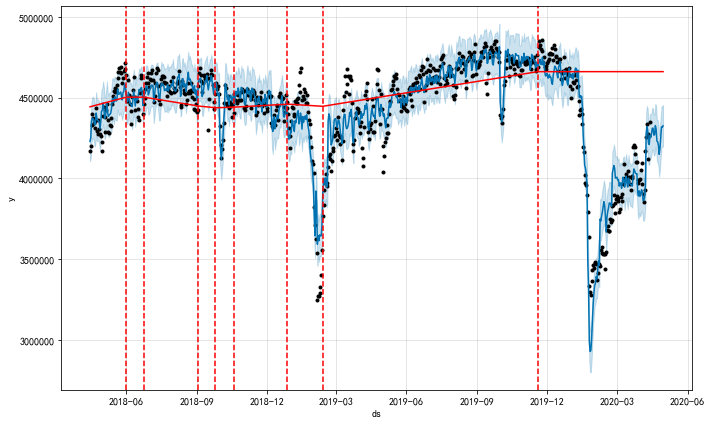

In [90]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)